<a href="https://colab.research.google.com/github/camstillo/electrodynamics/blob/master/Final_Project_Antenna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import

In [19]:
from IPython import display

In [20]:
# Need to upgrade matplotlib for some PyVista plotting commands to work.
# Run this cell, then select "Runtime > Restart runtime" from the CoLab menu.
!pip install --upgrade matplotlib
!pip install matplotlib==3.1.3
display.clear_output()

In [21]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

display.clear_output()

In [22]:
# This simulation uses real values.
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

display.clear_output()

In [23]:
!pip install -U meshio
!apt-get install python-lxml
!meshio-convert perfect_contact.msh perfect_contact.xdmf
import meshio

display.clear_output()

In [24]:
try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx
    
    display.clear_output()

In [25]:
# Everything should be installed now.
# Import the rest of what we need.
import gmsh

from dolfinx import fem, mesh, plot, la
from dolfinx.io import gmshio
import ufl

from mpi4py import MPI
import petsc4py.PETSc as petsc

import numpy as np
import pyvista

# Start a virtual plot window for PyVista in CoLab.
!sudo apt install libgl1-mesa-glx xvfb
!apt-get update
pyvista.start_xvfb()
pyvista.set_jupyter_backend("pythreejs")

# Get tools for embedding movies in CoLab.
from base64 import b64encode

display.clear_output();

#GMSH file import/Boundary Condition definition

In [26]:
from dolfinx.io import gmshio

# MPI communicator
comm = MPI.COMM_WORLD

file_name = "Mesh1.msh"
domain, cell_tags, _ = gmshio.read_from_msh(file_name, comm, rank=0, gdim=3)

# Prepare the mesh for plotting.
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(domain)

# Turn the mesh into a PyVista grid.
grid = pyvista.UnstructuredGrid(topology, cells, geometry)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(grid, style='wireframe')
plotter.view_xy()

# Save the HTML file.
plotter.export_html("./grid.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/grid.html')

In [27]:
#Define mesh variables
h = 0.15
lc = 0.5
tol = 1.0e-12
eCoax = 2.3    #dielectric constant of RG-58 coax
eSpace = 1.0   #dielectric constant of space around antenna 

#Define wave vector parameters
#Set potential amplitude
V0 = 10.0
V_theta = 0.0

#set current amplitude
J0 = 10.0

# Set the frequency of the wave.
f = 1e6
omega = 2 * np.pi * f

# Set the background index of refraction.
n0 = eSpace

# Set the wave speed.
c = 3e10

# Compute the wave vector.
k0 = n0 * omega / c

In [28]:
# import math
# import dolfin as dolFunction

# class PEC(SubDomain):   #Perfect Electric Conductor Class
#     def inside(self, x, on_boundary):
#         return on_boundary

# class InputBC(SubDomain):   #I/O port class 
#     def inside(self, x, on_boundary):
#         return on_boundary and dolFunction.near(x[2], -h-lc, tol) #z = -h-lc, tolerence = tol *see  near function

# class OutputBC(SubDomain):  #Radiation Boundary
#     def inside(self, x, on_boundary):
#         r_b = math.sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2])
#         r_c = math.sqrt(x[0]*x[0] + x[1]*x[1])
#         return on_boundary and ((dolFunction.near(r_b, 2.0, 5e-2) and x[2] > 0.0) or 
#                                 (dolFunction.near(r_c, 2.0, 5e-2) and dolFunction.between(x[2], (-h, 0))))
        
# class PMC(SubDomain):   #Symmetry plane
#     def inside(self, x, on_boundary):
#         return on_boundary and dolFunction.near(x[0], 0.0, tol)


In [29]:
# #Vectors for boundary conditions
# n_hat = ufl.FacetNormal()

#Define J and Boundary Conditions

In [30]:
import multiphenicsx.fem
import multiphenicsx.io

In [31]:

x = ufl.SpatialCoordinate(domain)
#Dirichlet = boundary condition function constant 
#Neumann = boundary condition function derivative constant

#Complex number is used to account for helmholtz, but fenics uses it to find just the magnitude of the field at different point, so time dependence disappears
#only electric field needs to be found b/c the B field is B = e(r) x E0
#neumann describes open boundary conditions, dirichlet describes clamped
#follow Helmholz and "colab movie" notebooks to find how to set boundary conditions based on facets of different objects
#Use multipheics to observe what the output of the tags are and then set BC's accordingly
#Look at magnetic field ring equation to see how current density was used to set current densities in different wires (i.e areas w/ tags having some current density)

# #First we have to set the boundary conditions because the 
# def uD_function(t):
#     return lambda x: J0*np.cos(2*np.pi*x[2]) #Jz = J0 * cos(2piZ/lambda) "ask if decaying expontial is correct here?"
#     # return lambda x: x[1] * np.cos(t)

# # Turn this function definition into a time-dependent function on the mesh.
# uD = fem.Function(V)

# # Initialize the function for t=0.
# t = 0
# uD.interpolate(uD_function(t))

# Define functions for current density and magnetic permeability.
Q = dolfinx.fem.VectorFunctionSpace(domain, ("DG", 0))
J = dolfinx.fem.Function(Q)
expr = fem.Expression(ufl.as_vector((0, 0, J0*ufl.cos(2*np.pi*x[2]/4))), Q.element.interpolation_points())
J.interpolate(expr)

# multiphenicsx.io.plot_vector_field(J, "J")

# Only some regions carry current. Initialize all current densities to zero.
J.x.array[:]

array([0.        , 0.        , 9.98456439, ..., 0.        , 0.        ,
       8.69547784])

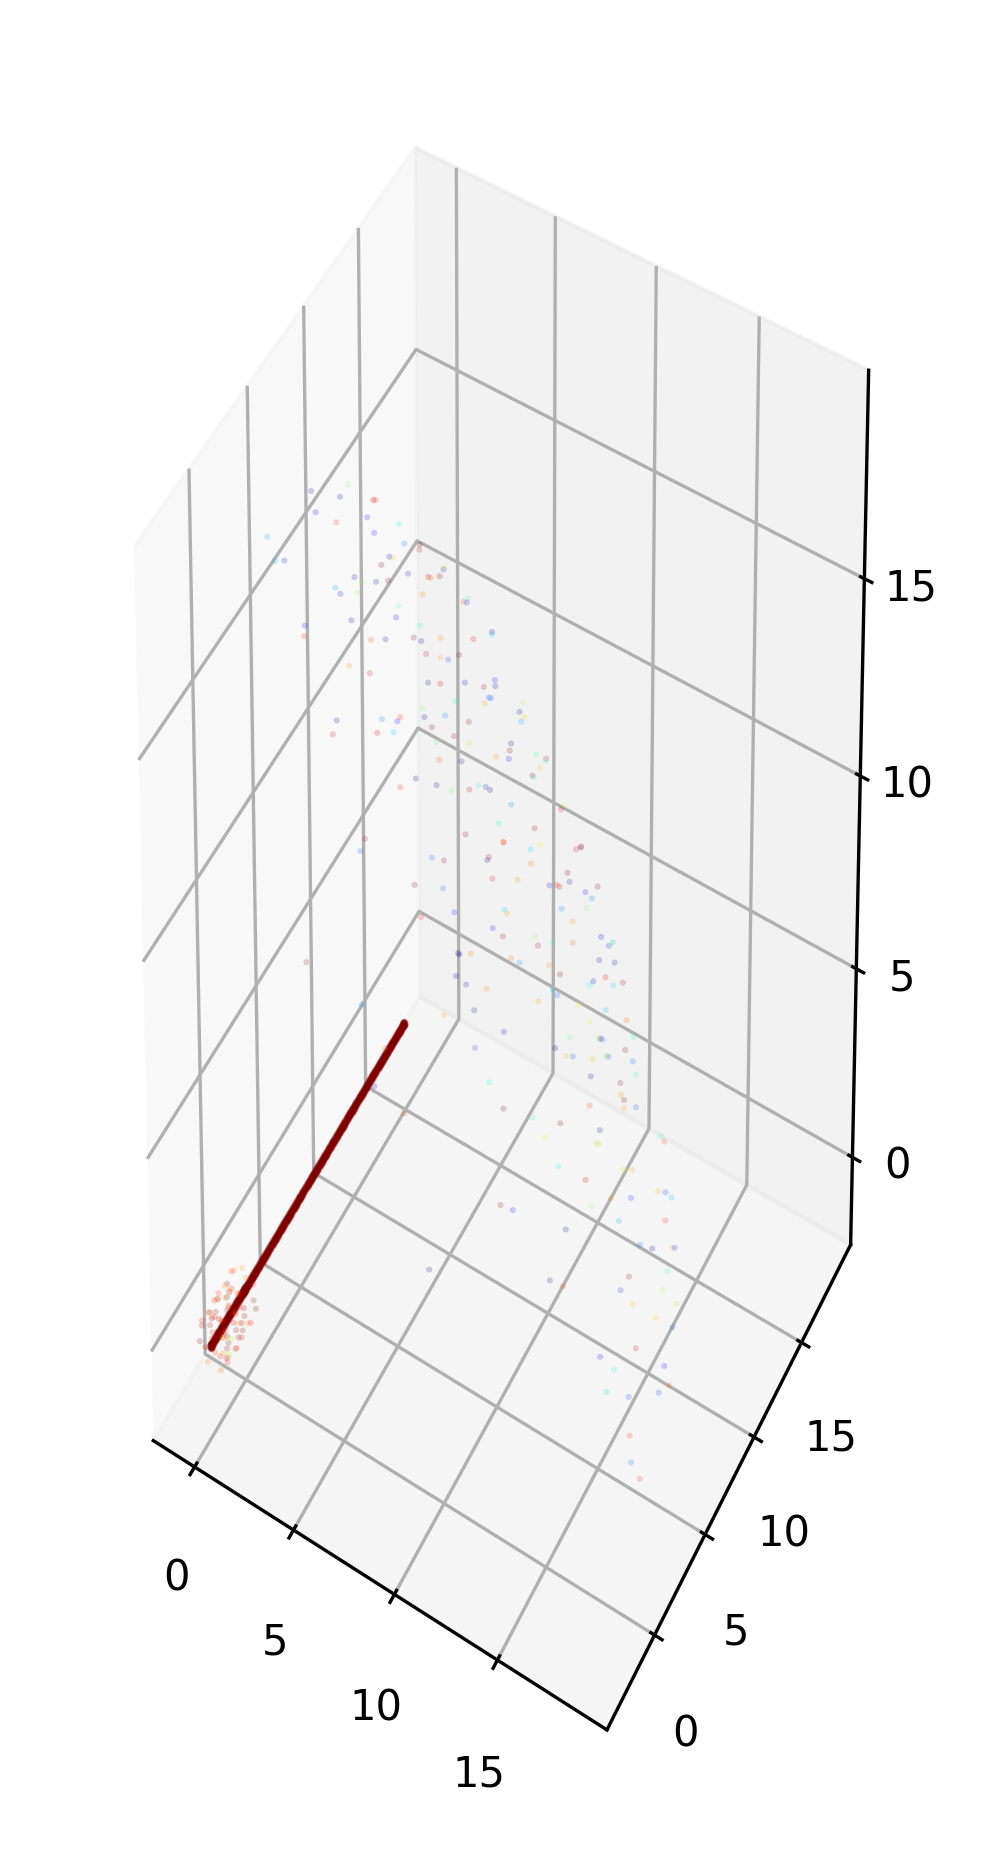

In [32]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
coordinates = Q.tabulate_dof_coordinates()
xx = coordinates[:,0]
yy = coordinates[:,1]
zz = coordinates[:,2]
j_vals = J.x.array.reshape(-1, 3)

fig = plt.figure(dpi=300, figsize=(4,8))
Ax = fig.add_subplot(projection = "3d")
Ax.scatter3D(xx, yy, zz, c=j_vals[:,2], cmap='jet', s=0.2, alpha=0.2)

In [33]:
zero = dolfinx.fem.Constant(domain, petsc.ScalarType(0.0))

source_function = dolfinx.fem.Expression(ufl.as_vector((zero, zero, J0*ufl.cos(x[2]))), Q.element.interpolation_points())
zero_function = dolfinx.fem.Expression(ufl.as_vector((zero,zero,zero)), Q.element.interpolation_points())

material_tags = np.unique(cell_tags.values)
for tag in material_tags:
    cells = cell_tags.find(tag)
    
    # Set nonzero current densities.
    if tag == 20:
        J.interpolate(source_function, cells)
    else:
        J.interpolate(zero_function, cells)

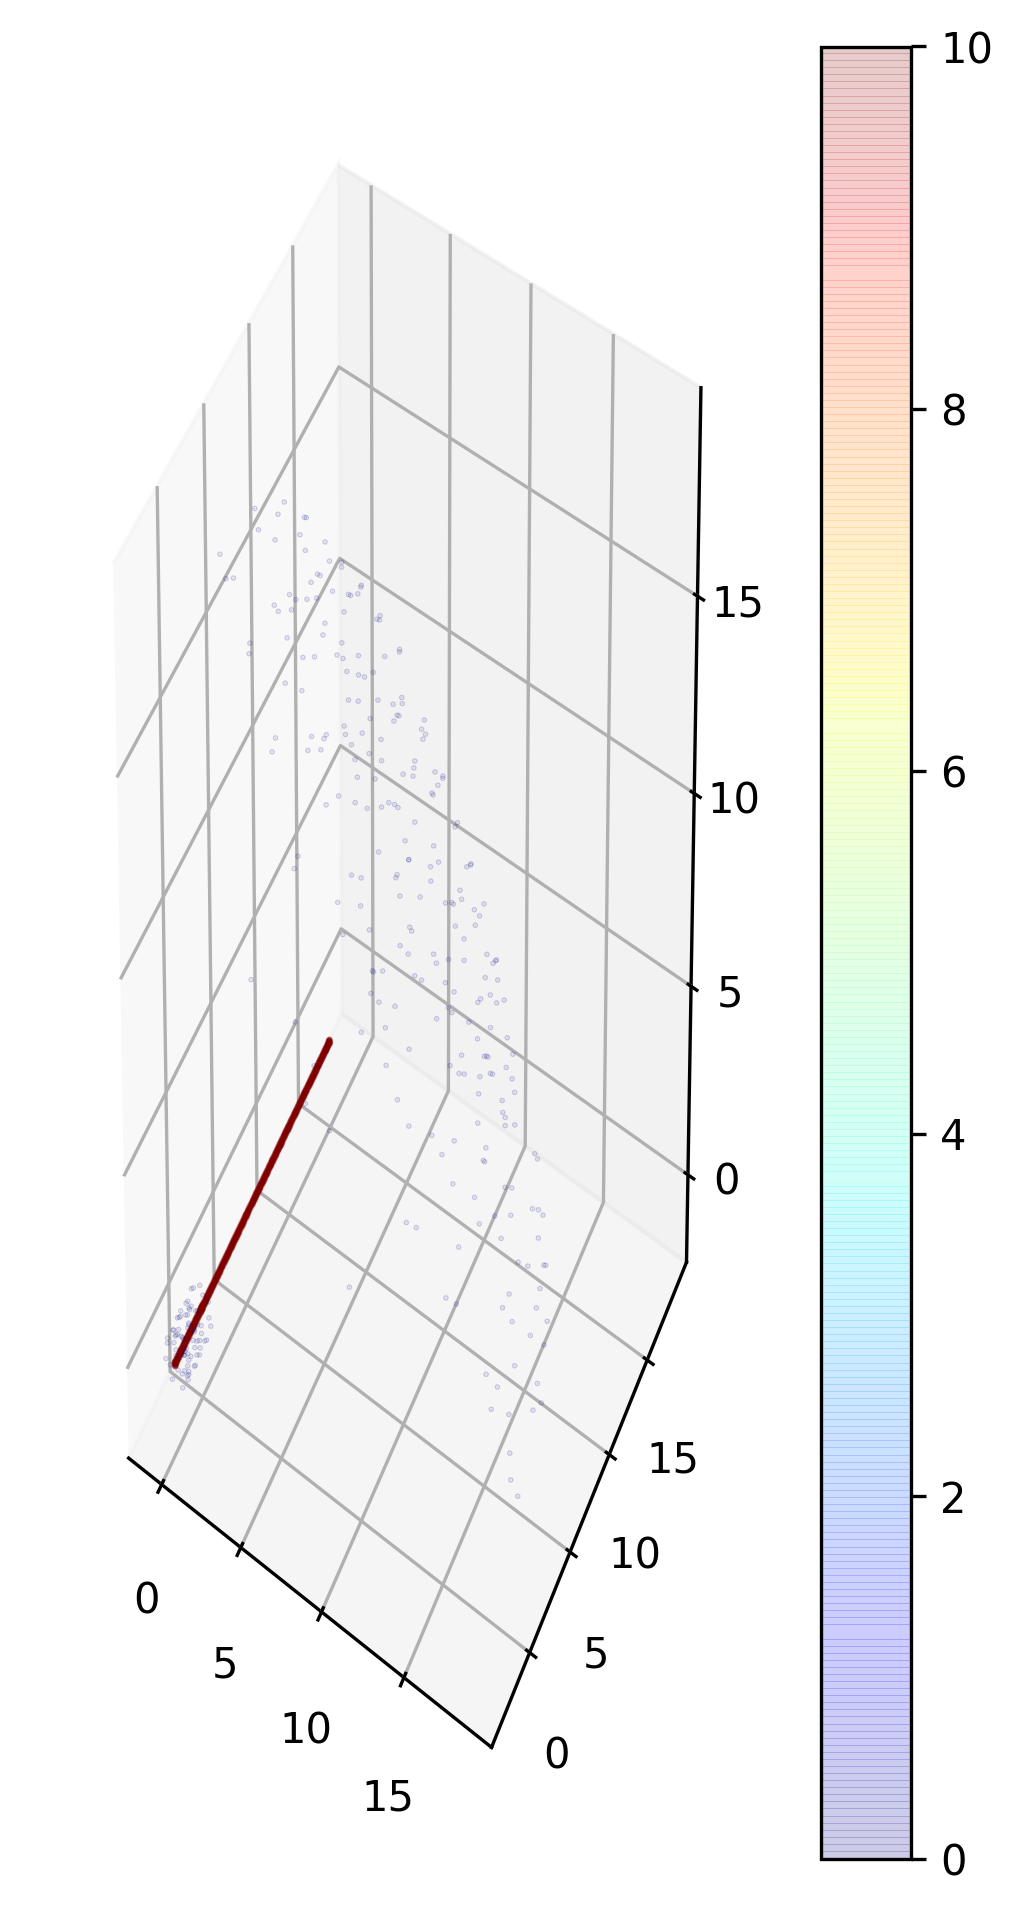

In [34]:
J_vals = J.x.array.reshape(-1,3)

#Make a scatterplot with matplotlib
fig = plt.figure(dpi=300, figsize=(4,8))
ax = fig.add_subplot(projection='3d')
cb = ax.scatter(xx,yy,zz,c=J_vals[:,2], cmap='jet', s=0.1, alpha=0.2)
plt.colorbar(cb)

#Define and Solve Problem with FEniCS

In [35]:
n_hat = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)
phi0 = ufl.exp(1j * k0 * x[0])          #i*k0*x
g = ufl.dot(ufl.grad(phi0), n_hat) + 1j * k0 * phi0   #(grad(phi0) dot n_hat) + i*k0*phi0 see notebook 11

r = ufl.as_vector((ufl.sqrt(x[0]**2 + x[1]**2 + x[2]**2), zero, zero))
display.clear_output()

In [39]:
V = dolfinx.fem.VectorFunctionSpace(domain, ("Lagrange", 2))

# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
A = fem.Function(V)
# f = fem.Constant(0.0)
# L = f


# This is the FEM version of the Helmholtz equation.
# It includes a boundary term, indicated by "ds".
a =  ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx \
    + (omega**2 / c) * ufl.inner(u, v) * ufl.dx

source_term = -1 * (4*ufl.pi / c) * ufl.inner(J, v) * ufl.dx 
            # + 2.0 * k0 * ufl.inner(v, ufl.cross(n_hat, r))

bc_term = 2.0 * k0 * ufl.inner(v, ufl.cross(n_hat, r)) * ufl.dx

# This is the boundary condition.
# L = ufl.inner(g, v) * ufl.ds + source_term
# L = ufl.finiteelement.enrichedelement.EnrichedElement(source_term, bc_term)
L = source_term #+ bc_term

# Put it all together for FEniCSx.
problem = fem.petsc.LinearProblem(a, L, u=A, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# Now, solve it!
problem.solve()

# Tie up some loose ends.
A.vector.ghostUpdate(addv=petsc.InsertMode.INSERT, mode=petsc.ScatterMode.FORWARD)

display.clear_output()

In [40]:
multiphenicsx.io.plot_vector_field(A, "vector potential")

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…